<a href="https://colab.research.google.com/github/nathantthai/SFL-SDE/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
__author__ = "Nathan Thai"
__email__ = "nathantthai@gmail.com"
__phone__ = "832-528-7224"

# Section 1

---
# Section 2
###Database & Python ETL

```mermaid
graph LR
A[CSV] -- EXTRACT --> B[Pandas DataFrame] --TRANSFORM -->C((List of Dictionaries)) -- 
LOAD --> D{noSQL MongoDB}
```



Importing modules

In [2]:
import pandas as pd
import os
!pip install pymongo
import pymongo # often, this will need to be pip installed in, see line above
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.1/492.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 12.4 MB/s eta 0:00:00


Setting up MongoDB with Python

In [4]:
# Credential params required to establish connection with MongoDB
provided_URI = "mongodb+srv://cluster0.rqb9xp1.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
path_to_certificate = "/content/X509-cert-359057758107592091.pem"

# Initializing a MongoClient Object, which is a MongoDB instance in the system
client = MongoClient(provided_URI,
                     tls=True,
                     tlsCertificateKeyFile=path_to_certificate,
                     server_api=ServerApi('1'))

# Initializing a database within the instance
database = client['SFL_SDE_evaluation_nathan']

# Initializing a collection within the database
collection = database['SRDataEngineerChallenge_DATASET']



Reading in the csv with pandas




In [5]:
# Enter CSV path
csv_url = '/content/SRDataEngineerChallenge_DATASET.csv'

# Using read_csv function from pandas to read in the csv
df = pd.read_csv(csv_url)

# A quick preview what the dataframe looks like
df.head()


,id,first_name,last_name,email,gender,ip_address
0,1,Margaretta,Laughtisse,mlaughtisse0@mediafire.com,Genderfluid,34.148.232.131
1,2,Vally,Garment,vgarment1@wisc.edu,Bigender,15.158.123.36
2,3,Tessa,Curee,tcuree2@php.net,Bigender,132.209.143.225
3,4,Arman,Heineking,aheineking3@tuttocitta.it,Male,157.110.61.233
4,5,Roselia,Trustie,rtrustie4@ft.com,Non-binary,49.55.218.81


Converting the dataframe into a list of dictionaries

In [6]:
# Initializing column name as key
id = df.columns[0]
first_name = df.columns[1]
last_name = df.columns[2]
email = df.columns[3]
gender = df.columns[4]
ip_address = df.columns[5]

# initializing an empty list to append to
df_in_listFormat = list()

'''
  Nesting a dictionary into a list, 
  e.g 
  [{'id': 1, 
  'first_name':'Margaretta', 
  'last_name':'Laughtisse', 
  'email':'mlaughtisse0@mediafire.com', 
  'gender':'Genderfluid', 
  'ip_address':'34.148.232.131'}]
'''

for row in df.itertuples(index=False):
  # creating a dictionary of key, value from column name, value
  dictionary ={id: row.id, 
               first_name: row.first_name,
               last_name: row.last_name,
               email: row.email,
               gender: row.gender,
               ip_address: row.ip_address
               }
  
  # appending it to the list
  df_in_listFormat.append(dictionary)


Inserting the list into the collection to the MongoDB

In [7]:
collection.insert_many(df_in_listFormat)


A screenshot result of the noSQL database on MongoDB

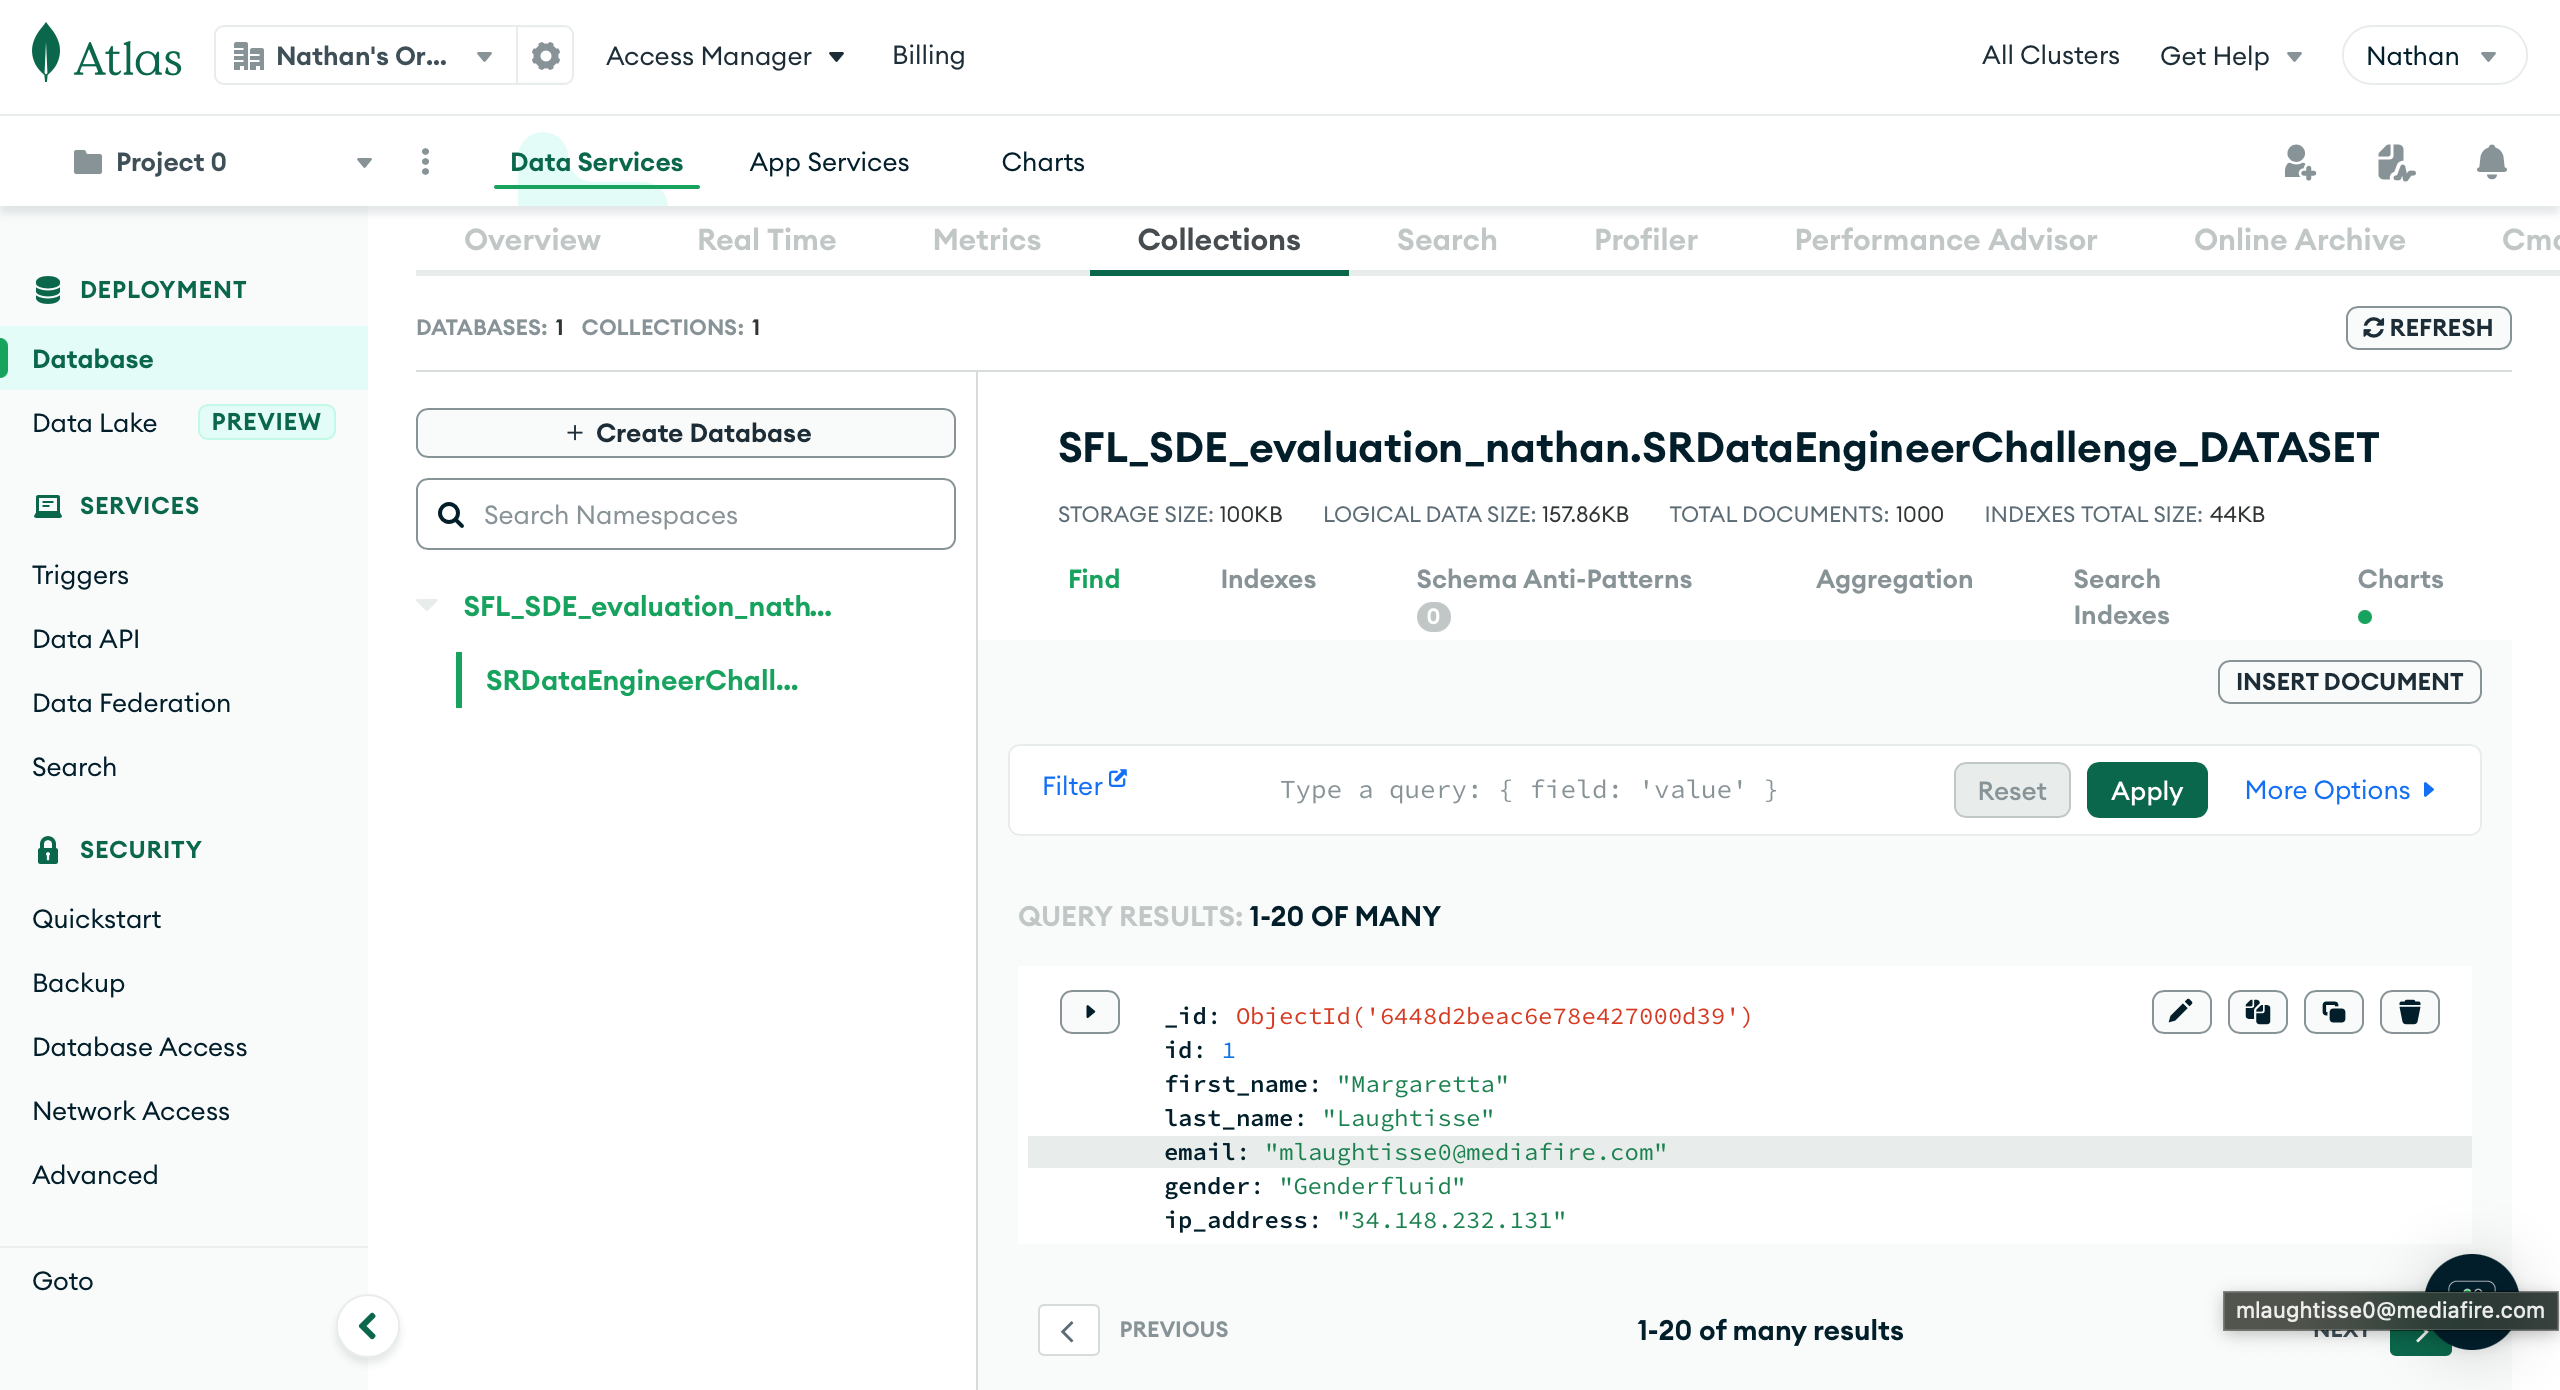

---
# Section 3
###ML API

Importing modules, eg. Pytorch, Pytorchlightning and Mnist Data

In [8]:
!pip install lightning
!pip install torch

import json
import lightning as L
import torch as T
import torch.nn.functional as F

from torch import nn
from torchmetrics.functional import accuracy
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from torchvision.datasets import MNIST, FashionMNIST #Importing the MNIST Dataset from torchvision. It is a Hello-World dataset and any ML dataloader library should have them

!pip install attrdict
!pip install nvidia-pyindex
!pip install tritonclient[all]

import attrdict
import tritonclient
import numpy as np
import tritonclient.http as httpclient
from tritonclient.utils import triton_to_np_dtype

# Global Var
DATASET_PATH = os.environ.get("PATH_DATASETS", ".")
INPUT_DIM = (1, 28, 28) # 28 by 28 grayscale input, 1 channel eg. (c, w, h)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [22]:
class Model(L.LightningModule):
    def __init__(self, channels, width, height, num_classes, hidden_size=64, learning_rate=2e-3):
        super().__init__()

        # Initializing params eg. input dimensions .. to build the model.
        self.width = width
        self.height = height
        self.channels = channels
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = T.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = T.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=10)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = T.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

Setting up the dataloader to feed data into training



In [10]:
class MNISTModule(L.LightningDataModule):
    def __init__(self, data_dir: str = DATASET_PATH):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)), # not sure about these params but Yann LeCun likes them.
            ]
        )

        self.dims = INPUT_DIM 
        self.num_classes = 10 # 10 digits

    def prepare_data(self):
        # downloading and creating the proper directories to save them
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign training/validation datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=64)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=64)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=64)

In [25]:
# Initializing DataModule
datamodule = MNISTModule()
# Initializing Model from datamodule's attributes
model = Model(*datamodule.dims, datamodule.num_classes)
# Initializing the trainer
trainer = L.Trainer(
    max_epochs=1,
    accelerator="auto",
    devices="auto",
)
# fit DataModule to model
trainer.fit(model, datamodule)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 55.1 K
-------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 55.1 K
-------------------------------------
55.1 K    Trainable params
0         Non-trai

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Saving the checkpoint to torchscript file for deployment

In [12]:
saved_model = model.to_torchscript()
T.jit.save(saved_model, '/content/model.pt')

Setting up a NVIDIA Triton Inference Server inside a Docker Container on GCP.



```
# In Ubuntu 18.04, if Docker is not installed
sudo snap install docker
```

```
# Create the model repository, the latest version is 23.04 but 23.03 will do
git clone -b r23.03 https://github.com/triton-inference-server/server.git

```



```
# Setting up the deployment directory where we deploy model.pt

model_repository
|
+-- mnist
    |
    +-- config.pbtxt
    +-- 1
        |
        +-- model.pt
```

```
#  config.pbtxt must be configured as following

name: "mnist"
platform: "pytorch_libtorch"
max_batch_size : 0
input [
  {
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ 1, 28, 28, -1 ]
  }
]
output [
  {
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ -1, 10]
  }
]
```

```
# Initiate a Triton Docker Container, with CPUs
docker run --rm --net=host -v ${PWD}/model_repository:/models nvcr.io/nvidia/tritonserver:23.03-py3 tritonserver --model-repository=/models
```







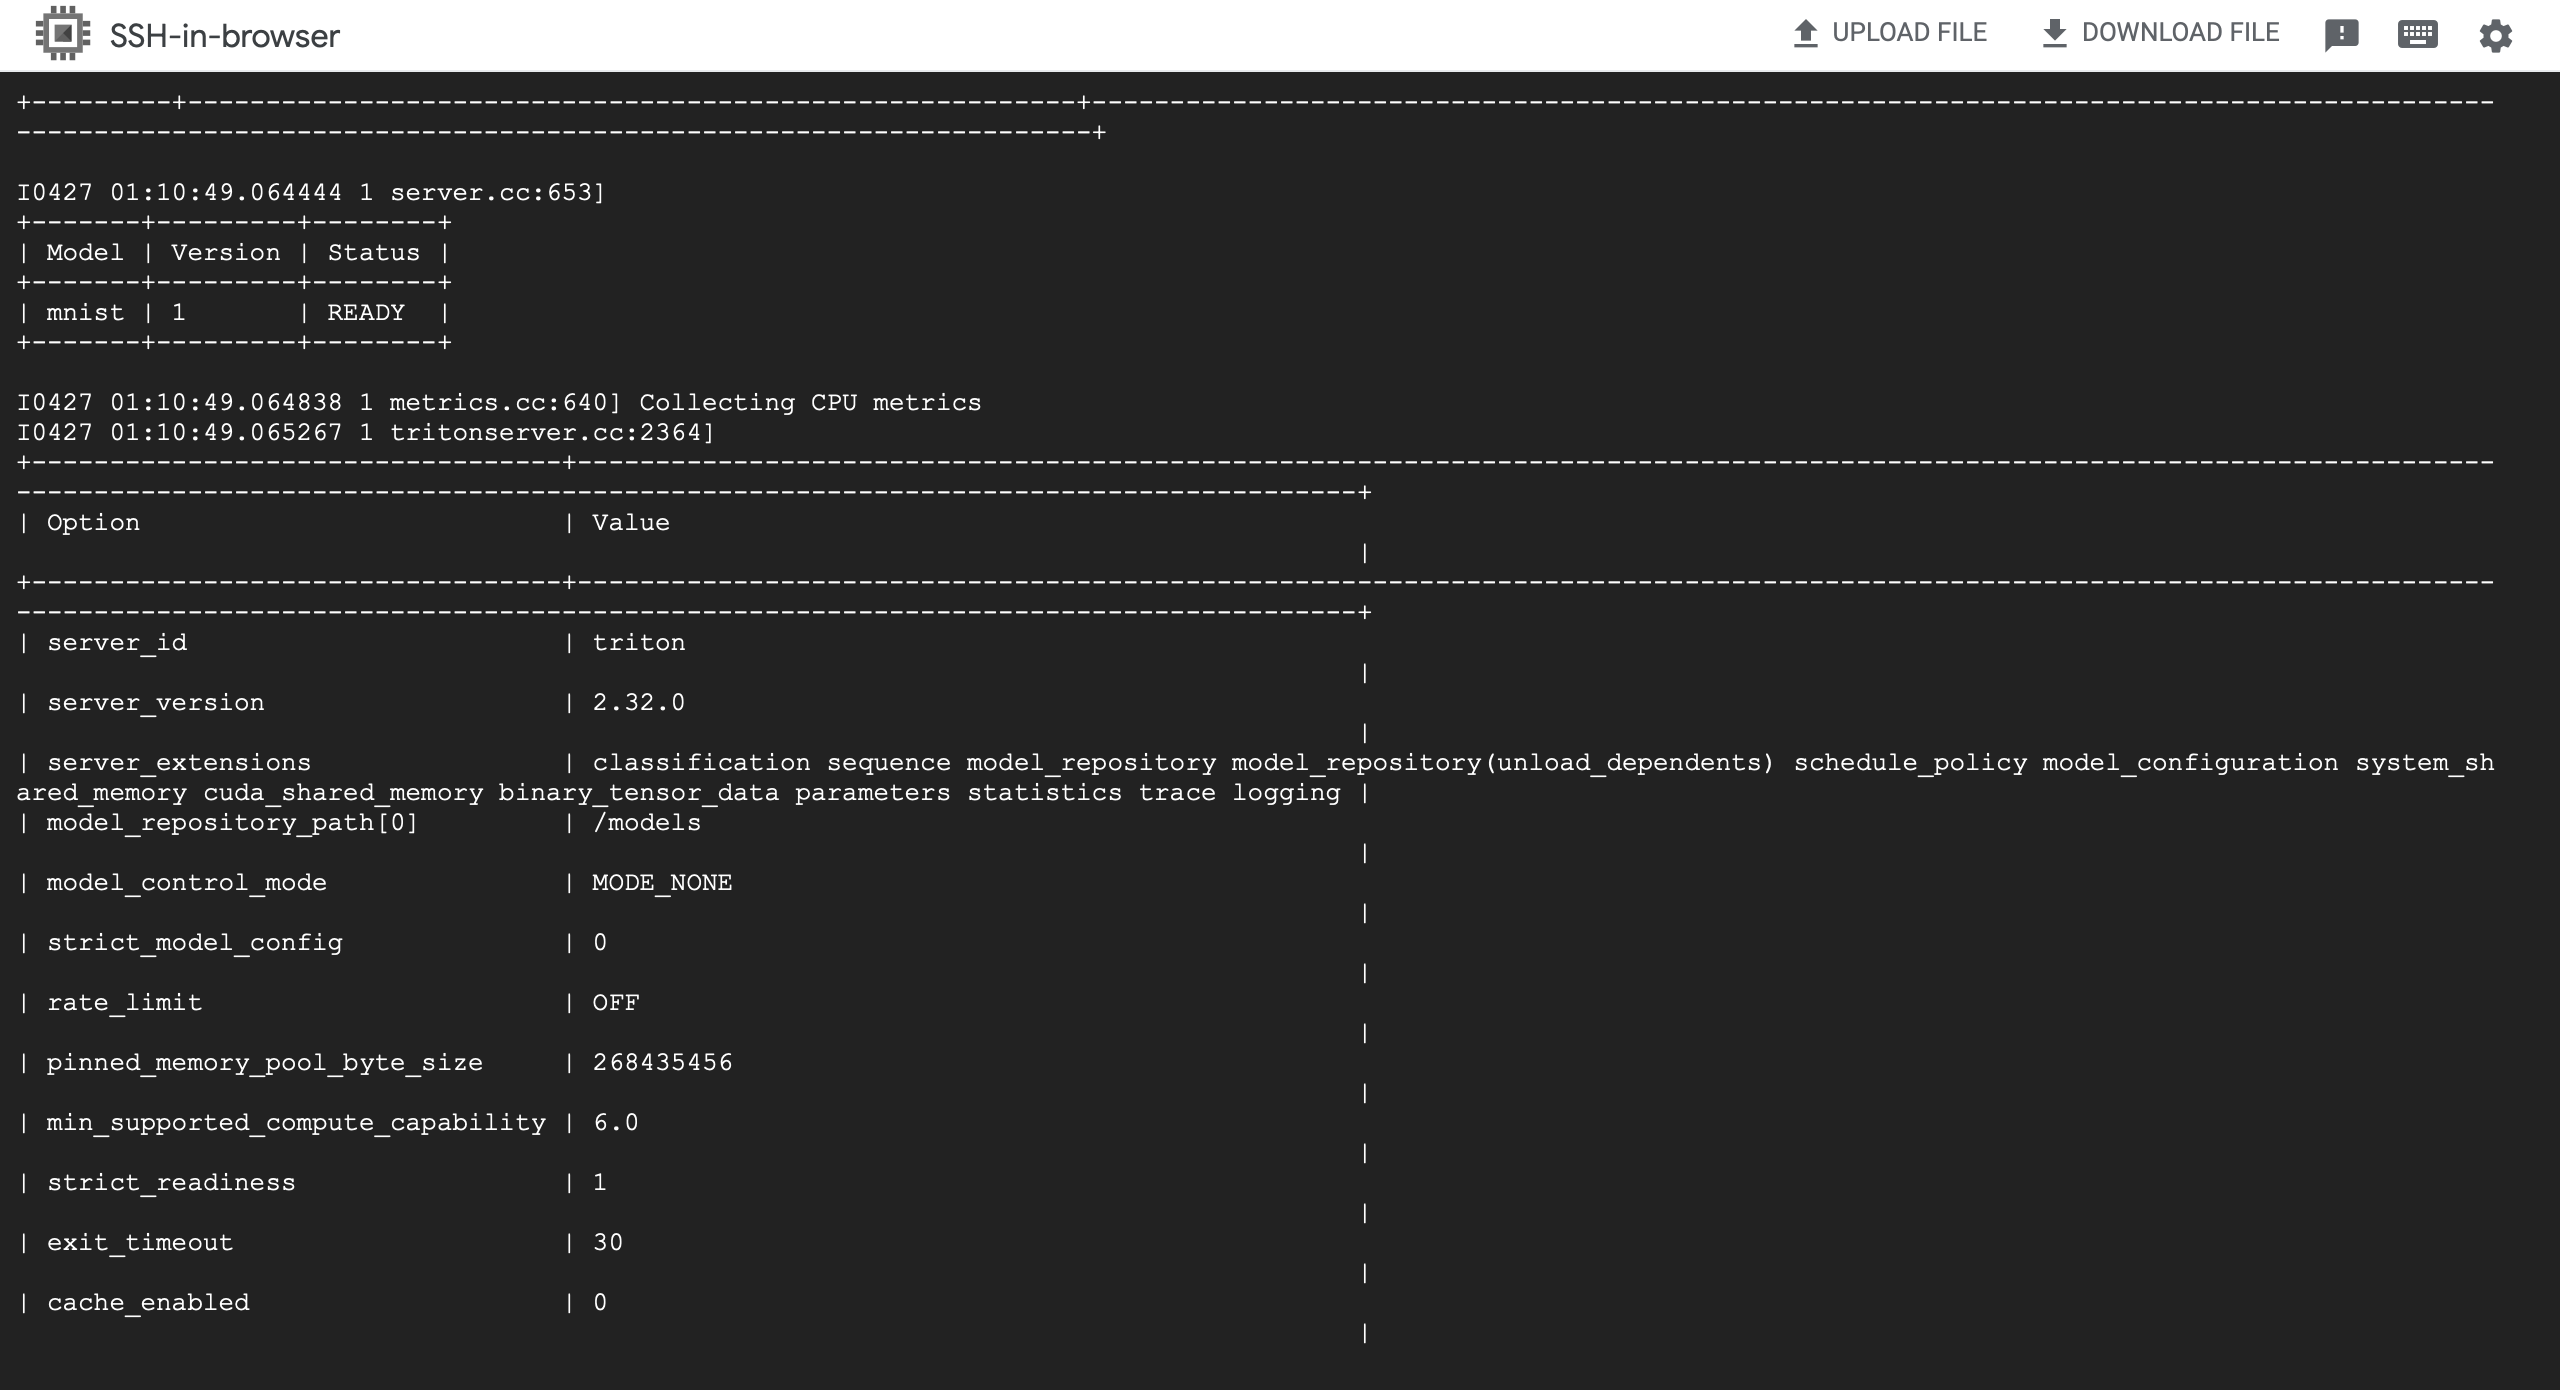

In [63]:
# Pulling the test set
test_set =MNIST(root='./data', train=False, download=True, transform=None)

# Making example inference requests
for count, image_label in enumerate(test_set):
  # showing the image
  image = image_label[0]

  # Setting up client, Google Cloud Computer IP address is 34.136.246.142 and we opened the port 8000 for the container
  client = httpclient.InferenceServerClient(url="34.136.246.142:8000")
  test_image = np.array(T.tensor(np.array(image).astype(np.float32)))
  test_image = np.expand_dims(test_image, axis = (0, 3)) # to make its shape to (1, 28,28,1)
  inputs = httpclient.InferInput("input__0", test_image.shape, datatype="FP32")

  inputs.set_data_from_numpy(test_image, binary_data=True)
  outputs = httpclient.InferRequestedOutput("output__0", binary_data=True, class_count=10)

  # Querying the server, an inference request to the Triton Inference Server
  results = client.infer(model_name="mnist", inputs=[inputs], outputs=[outputs])
  inference_output = results.as_numpy('output__0')
  result = inference_output[np.argmax(inference_output)]

  # show image
  image.show()
  # converting byte to string and split
  print(f"Prediction: {result.decode('utf-8').split(':')[1]}")

  if count == 10:
    break

Prediction: 7


Prediction: 2


Prediction: 1


Prediction: 0


Prediction: 4


Prediction: 1


Prediction: 4


Prediction: 9


Prediction: 6


Prediction: 9


Prediction: 0
